In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datacompy
import os, sys
import numpy as np

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy import stats
from joblib import dump, load

# modele
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# methods
from imblearn.under_sampling import ClusterCentroids, NearMiss
from scipy.optimize import differential_evolution
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

## Data

### Read data

In [24]:
#oversampling data
original_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\original_data.csv")    
original_data = original_data.drop(columns=["Unnamed: 0"])
smote_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote_data.csv")
GAN_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN_data.csv")
borderline_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderline_data.csv")
smote2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote3_data.csv")
GAN2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN3_data.csv")    
borderline2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderline3_data.csv")

# test data
X_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\y_test.csv")


""" #undersampling prepare data //mixed data (gan, brdsmote, smote)
cc_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\clustercentroids_data.csv")
if_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\isolationforest_data.csv")
nm_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\nearmiss_data.csv")
median_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\median_data.csv")
lof_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\localoutlierfactor_data.csv") """


' #undersampling prepare data //mixed data (gan, brdsmote, smote)\ncc_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\clustercentroids_data.csv")\nif_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\isolationforest_data.csv")\nnm_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\nearmiss_data.csv")\nmedian_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\median_data.csv")\nlof_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\localoutlierfactor_data.csv") '

In [25]:
print(original_data["target"].value_counts())
count1=original_data["target"].value_counts().sum()
print(count1)
count2=abs((original_data['target']==0).sum() - (original_data['target']==1).sum())
print(f"Before undersampling: {count2}")
print(f"After number of samples: {count1+count2}")

target
0    151
1     46
Name: count, dtype: int64
197
Before undersampling: 105
After number of samples: 302


### Preprocessing Data

In [26]:
#mixed data
mix_data = pd.concat([GAN_data, smote_data, borderline_data, original_data], axis=0, ignore_index=True)         
mix_data = mix_data.reset_index(drop=True)

#data with one oversampling method and original data e.g.(smote+original)
smote_data = pd.concat([smote_data, smote2_data, original_data], axis=0, ignore_index=True)
smote_data = smote_data.reset_index(drop=True)
borderline_data = pd.concat([borderline_data, borderline2_data, original_data], axis=0, ignore_index=True)
borderline_data = borderline_data.reset_index(drop=True)
GAN_data = pd.concat([GAN_data, GAN2_data, original_data], axis=0, ignore_index=True)
GAN_data = GAN_data.reset_index(drop=True)

sum_all_data = pd.concat([smote_data, GAN_data, borderline_data, mix_data], axis=0, ignore_index=True)

#### Split data

In [27]:
X_mix, y_mix = mix_data.drop(columns=["target", "source"]), mix_data["target"]
X_smote, y_smote = smote_data.drop(columns=["target", "source"]), smote_data["target"]
X_GAN, y_GAN = GAN_data.drop(columns=["target", "source"]), GAN_data["target"]
X_borderline, y_borderline = borderline_data.drop(columns=["target", "source"]), borderline_data["target"]

#### Dictionary

In [28]:
data = {}
data["mix"] = (X_mix, y_mix)
data["smote"] = (X_smote, y_smote)
data["GAN"] = (X_GAN, y_GAN)
data["borderline"] = (X_borderline, y_borderline)

compare = {}
compare["mix"] = mix_data
compare["smote"] = smote_data
compare["GAN"] = GAN_data
compare["borderline"] = borderline_data

## Undersampling

### NearMiss version1

In [29]:
NM = NearMiss(version=1)

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_NM, y_NM = NM.fit_resample(X_train, y_train)
    
    #concat resampled data
    nearmiss_data = pd.concat([X_NM, y_NM], axis=1)
    
    NM_data_nosource = compare_df.drop(columns=["source"])
    nearmiss_data_nosource = nearmiss_data

    for index, row in nearmiss_data_nosource.iterrows():
        match = NM_data_nosource.eq(row).all(axis=1)  # Sprawdza, gdzie wiersze są identyczne
        if match.any():  # Jeśli znaleziono dopasowanie
            matched_index = match.idxmax()  # Pobiera pierwszy pasujący indeks
            nearmiss_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
            
    nearmiss_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_NM_data.csv")
    
    print(f"Data reduced for {name} data")
    print(nearmiss_data["target"].value_counts())
    

Data reduced for mix data
target
0    151
1    151
Name: count, dtype: int64
Data reduced for smote data
target
0    151
1    151
Name: count, dtype: int64
Data reduced for GAN data
target
0    151
1    151
Name: count, dtype: int64
Data reduced for borderline data
target
0    151
1    151
Name: count, dtype: int64


### K-means

In [30]:
KM = KMeans(n_clusters=(int)((count1+count2)/2))

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_majority = X_train[y_train == 1]
    X_minority = X_train[y_train == 0]
    
    kmeans = KM.fit(X_majority)
    
    X_majority_reduced = pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)
    y_majority_reduced = pd.Series([0] * (int)((count1+count2)/2), name="target")
    
    X_minority = X_minority.reset_index(drop=True)
    y_minority = pd.Series([1] * len(X_minority), name="target")
    
    X_final = pd.concat([X_majority_reduced, X_minority], axis=0).reset_index(drop=True)
    y_final = pd.concat([y_majority_reduced, y_minority], axis=0).reset_index(drop=True)
    
    # Concat resampled data
    reduced_data = pd.concat([X_final, y_final], axis=1)
    
    reduced_data["source"] = None  # Initialize the source column with None
    
    # Compare data to copy source column
    data_nosource = compare_df.drop(columns=["source"])
    reduced_data_nosource = reduced_data

    # Iterate through the rows in reduced_data_nosource
    for index, row in reduced_data_nosource.iterrows():
        match = data_nosource.eq(row).all(axis=1)  # Check where rows are identical
        if match.any():  # If a match is found
            matched_index = match.idxmax()  # Get the first matching index
            reduced_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
            
    # Check for any rows that still have None in the source column
    missing_source = reduced_data[reduced_data["source"].isna()]
    if not missing_source.empty:
        reduced_data.loc[reduced_data["source"].isna(), "source"] = "centroid"       
    
    reduced_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_KM_data.csv", index=False)
    
    print(f"Data reduced for {name} data")
    print(reduced_data["target"].value_counts())

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for mix data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for smote data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for GAN data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for borderline data
target
0    151
1    151
Name: count, dtype: int64


### ClusterCentroids

In [31]:
CC = ClusterCentroids(sampling_strategy="majority", voting="auto")

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_CC, y_CC = CC.fit_resample(X_train, y_train)
    
    # Concat resampled data
    reduced_data = pd.concat([X_CC, y_CC], axis=1)
    
    # Compare data to copy source column
    data_nosource = compare_df.drop(columns=["source"])
    reduced_data_nosource = reduced_data.drop(columns=["source"], errors='ignore')

    reduced_data["source"] = None  # Initialize the source column with None

    # Iterate through the rows in reduced_data_nosource
    for index, row in reduced_data_nosource.iterrows():
        match = data_nosource.eq(row).all(axis=1)  # Check where rows are identical
        if match.any():  # If a match is found
            matched_index = match.idxmax()  # Get the first matching index
            reduced_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
    
    # Check for any rows that still have None in the source column
    missing_source = reduced_data[reduced_data["source"].isna()]
    if not missing_source.empty:
        reduced_data.loc[reduced_data["source"].isna(), "source"] = "centroid"
    
    reduced_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_CC_data.csv", index=False)
    
    print(f"Data reduced for {name} data")
    print(reduced_data["target"].value_counts())

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for mix data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for smote data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for GAN data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for borderline data
target
0    151
1    151
Name: count, dtype: int64


## Learning

In [35]:
models = {}

models["LR"]        = LogisticRegression(max_iter=1000, random_state=0)
models["LR_mix"]    = LogisticRegression(max_iter=500, random_state=0)
models["LR_smote"]  = LogisticRegression(max_iter=500, random_state=0)
models["LR_GAN"]    = LogisticRegression(max_iter=100, random_state=0)
models["LR_borderline"] = LogisticRegression(max_iter=1000, random_state=0)

models["DT"]        = DecisionTreeClassifier(max_depth=8, min_samples_leaf=1, random_state=10)
models["DT_mix"]    = DecisionTreeClassifier(max_depth=8, min_samples_leaf=1, random_state=10)
models["DT_smote"]  = DecisionTreeClassifier(max_depth=8, min_samples_leaf=1, random_state=10)
models["DT_GAN"]    = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=10)
models["DT_borderline"] = DecisionTreeClassifier(max_depth=8, min_samples_leaf=1, random_state=10)

models["RF"]        = RandomForestClassifier(max_depth=8, min_samples_leaf=1, n_estimators=20, random_state=10)
models["RF_mix"]    = RandomForestClassifier(max_depth=8, min_samples_leaf=1, n_estimators=80, random_state=20)
models["RF_smote"]  = RandomForestClassifier(max_depth=4, min_samples_leaf=1, n_estimators=20, random_state=20)
models["RF_GAN"]    = RandomForestClassifier(max_depth=12, min_samples_leaf=1, n_estimators=40, random_state=10)
models["RF_borderline"] = RandomForestClassifier(max_depth=8, min_samples_leaf=1, n_estimators=20, random_state=10)

models["XGB"]       = XGBClassifier(max_depth=4, subsample=0.5)
models["XGB_mix"]   = XGBClassifier(max_depth=4, subsample=0.5)
models["XGB_smote"] = XGBClassifier(max_depth=4, subsample=0.9)
models["XGB_GAN"]   = XGBClassifier(max_depth=4, subsample=0.7)
models["XGB_borderline"] = XGBClassifier(max_depth=4, subsample=0.5)

models["XGBRF"]     = XGBRFClassifier(max_depth=4, subsample=0.8)
models["XGBRF_mix"] = XGBRFClassifier(max_depth=4, subsample=0.8)
models["XGBRF_smote"] = XGBRFClassifier(max_depth=4, subsample=0.7)
models["XGBRF_GAN"] = XGBRFClassifier(max_depth=4, subsample=0.7)
models["XGBRF_borderline"] = XGBRFClassifier(max_depth=4, subsample=0.8)

X_train_mix, y_train_mix = mix_data.drop(columns=["target", "source"]), mix_data["target"]
X_train_smote, y_train_smote = smote_data.drop(columns=["target", "source"]), smote_data["target"]
X_train_GAN, y_train_GAN = GAN_data.drop(columns=["target", "source"]), GAN_data["target"]
X_train_borderline, y_train_borderline = borderline_data.drop(columns=["target", "source"]), borderline_data["target"]

training_data = {}

training_data["LR"]= (X_train, y_train)
training_data["LR_mix"]= (X_train_mix, y_train_mix)
training_data["LR_smote"]= (X_train_smote, y_train_smote)
training_data["LR_GAN"]= (X_train_GAN, y_train_GAN)
training_data["LR_borderline"]= (X_train_borderline, y_train_borderline)

training_data["DT"]= (X_train, y_train)
training_data["DT_mix"]= (X_train_mix, y_train_mix)
training_data["DT_smote"]= (X_train_smote, y_train_smote)
training_data["DT_GAN"]= (X_train_GAN, y_train_GAN)
training_data["DT_borderline"]= (X_train_borderline, y_train_borderline)

training_data["RF"]= (X_train, y_train)
training_data["RF_mix"]= (X_train_mix, y_train_mix)
training_data["RF_smote"]= (X_train_smote, y_train_smote)
training_data["RF_GAN"]= (X_train_GAN, y_train_GAN)
training_data["RF_borderline"]= (X_train_borderline, y_train_borderline)

training_data["XGB"]= (X_train, y_train)
training_data["XGB_mix"]= (X_train_mix, y_train_mix)
training_data["XGB_smote"]= (X_train_smote, y_train_smote)
training_data["XGB_GAN"]= (X_train_GAN, y_train_GAN)
training_data["XGB_borderline"]= (X_train_borderline, y_train_borderline)

training_data["XGBRF"]= (X_train, y_train)
training_data["XGBRF_mix"]= (X_train_mix, y_train_mix)
training_data["XGBRF_smote"]= (X_train_smote, y_train_smote)
training_data["XGBRF_GAN"]= (X_train_GAN, y_train_GAN)
training_data["XGBRF_borderline"]= (X_train_borderline, y_train_borderline)

### GridSearch

In [34]:
params_ = {}

params_["LR"] = {
    'max_iter':[100,500,1000]  ,
    'random_state':[0,10,20,30,40]
}

params_["DT"] = {                           
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'random_state':[0,10,20,30,40],         # ustalona losowość dla powtarzalności
    'min_samples_leaf':[1,2]                # minimalna ilosc probek lisci
}

params_["RF"] = {
    'n_estimators':[20,40,60,80,100],       # rozmiar lasu
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'min_samples_leaf':[1,2],               # minimalna ilosc probek lisci
    'random_state':[0,10,20,30,40],         # ustalona losowość dla powtarzalności
}

params_["XGB"] = {                              
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'subsample':[0.5,0.6,0.7,0.8,0.9,1]
}

params_["XGBRF"] = {                           
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'n_estimators':[20,40,60,80,100],       # rozmiar lasu
    'subsample':[0.5,0.6,0.7,0.8,0.9,1],
    'random_state':[0,10,20,30,40]          # ustalona losowość dla powtarzalności
}

goal = ['accuracy','precision', 'recall', 'f1'] 
file_pathes = ["D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\accuracy.txt"
                ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\precision.txt"
               ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\recall.txt"
               ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\f1.txt"]

for score_1, file_path in zip(goal, file_pathes):
    for model_key, data_key in zip(models.keys(), training_data.keys()):
        model = models[model_key]
        data = training_data[data_key]
        
        param_grid = None
        for key in params_.keys():
            if model_key.startswith(key):
                param_grid = params_[key]
                break
        
        if param_grid is not None:
            grid_search = GridSearchCV(model, param_grid=param_grid, scoring=score_1, n_jobs=1).fit(data[0], data[1])
            print(f"{score_1} & {model_key}")
            with open(file_path, "a+") as f:
                print(f'scoring: {score_1}', file=f)
                print(f'Best parameters for {score_1} & {model_key}:', grid_search.best_params_, file=f)
                print(f'Best score for {score_1} & {model_key}:', grid_search.best_score_, file=f)

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_mix


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_smote


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_GAN


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_borderline
accuracy & DT
accuracy & DT_mix
accuracy & DT_smote
accuracy & DT_GAN
accuracy & DT_borderline
accuracy & RF
accuracy & RF_mix
accuracy & RF_smote
accuracy & RF_GAN
accuracy & RF_borderline
accuracy & XGB
accuracy & XGB_mix
accuracy & XGB_smote
accuracy & XGB_GAN
accuracy & XGB_borderline
accuracy & XGBRF
accuracy & XGBRF_mix
accuracy & XGBRF_smote
accuracy & XGBRF_GAN
accuracy & XGBRF_borderline


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_mix


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_smote


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_GAN


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_borderline
precision & DT
precision & DT_mix
precision & DT_smote
precision & DT_GAN
precision & DT_borderline
precision & RF
precision & RF_mix
precision & RF_smote
precision & RF_GAN
precision & RF_borderline
precision & XGB
precision & XGB_mix
precision & XGB_smote
precision & XGB_GAN
precision & XGB_borderline
precision & XGBRF
precision & XGBRF_mix
precision & XGBRF_smote
precision & XGBRF_GAN
precision & XGBRF_borderline


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_mix


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_smote


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_GAN


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_borderline
recall & DT
recall & DT_mix
recall & DT_smote
recall & DT_GAN
recall & DT_borderline
recall & RF
recall & RF_mix
recall & RF_smote
recall & RF_GAN
recall & RF_borderline
recall & XGB
recall & XGB_mix
recall & XGB_smote
recall & XGB_GAN
recall & XGB_borderline
recall & XGBRF
recall & XGBRF_mix
recall & XGBRF_smote
recall & XGBRF_GAN
recall & XGBRF_borderline


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_mix


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_smote


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_GAN


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_borderline
f1 & DT
f1 & DT_mix
f1 & DT_smote
f1 & DT_GAN
f1 & DT_borderline
f1 & RF
f1 & RF_mix
f1 & RF_smote
f1 & RF_GAN
f1 & RF_borderline
f1 & XGB
f1 & XGB_mix
f1 & XGB_smote
f1 & XGB_GAN
f1 & XGB_borderline
f1 & XGBRF
f1 & XGBRF_mix
f1 & XGBRF_smote
f1 & XGBRF_GAN
f1 & XGBRF_borderline


### Learning Models Cross-Vali

In [36]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
results_cross_mean_under=[]
results_cross_std_under=[]
goal = ['accuracy', 'precision','f1','recall']
path_files = ["D:\\ml\\undersampling_data\\reports\\ssh\\results\\accuracy_metrics.txt",
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\precision_metrics.txt", 
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\f1_metrics.txt", 
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\recall_metrics.txt"]

excel_file_cross = "D:\\ml\\undersampling_data\\reports\\ssh\\results\\cross.xlsx"
excel_file_cross2 = "D:\\ml\\undersampling_data\\reports\\ssh\\results\\cross_std.xlsx"
name_sheet1 = "Arkusz1"

model_scores = {}

for metrix1, path_file in zip(goal, path_files):
    for model_key, data_key in zip(models.keys(), training_data.keys()):
        model = models[model_key]
        X_train, y_train = training_data[model_key]
        cross_val_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=metrix1, n_jobs=1)
        print(f"Learn: {metrix1} and model {model_key}")
        with open(path_file, "a+") as f:
            # Zapis wyników do pliku
            print(f'{model_key} Cross-Validation Results {metrix1}:\n {cross_val_results}', file=f)
            print(f'Mean {metrix1}: {cross_val_results.mean()}', file=f)
            print(f'Dev: {cross_val_results.std()}', file=f)
            print("\n", file=f)
        
        results_cross_mean_under.append({
        "Model": model_key,
        "Metric": metrix1,
        "Result": cross_val_results.mean()})
        results_cross_std_under.append({
        "Model": model_key,
        "Metric": metrix1,
        "Std": cross_val_results.std()})
        df_results_cross_under_mean = pd.DataFrame(results_cross_mean_under)
        df_results_cross_under_std = pd.DataFrame(results_cross_std_under)
        df_save_under_mean = df_results_cross_under_mean.pivot(index="Metric", columns="Model", values="Result")
        df_save_under_std = df_results_cross_under_std.pivot(index="Metric", columns="Model", values="Std")
        
        with pd.ExcelFile(excel_file_cross) as w:
            df_save_under_mean.to_excel(w, sheet_name=name_sheet1)
        with pd.ExcelFile(excel_file_cross2) as w1:
            df_save_under_std.to_excel(w1, sheet_name=name_sheet1)


Learn: accuracy and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_mix


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_smote


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_GAN
Learn: accuracy and model LR_borderline
Learn: accuracy and model DT
Learn: accuracy and model DT_mix
Learn: accuracy and model DT_smote
Learn: accuracy and model DT_GAN
Learn: accuracy and model DT_borderline
Learn: accuracy and model RF
Learn: accuracy and model RF_mix
Learn: accuracy and model RF_smote
Learn: accuracy and model RF_GAN
Learn: accuracy and model RF_borderline
Learn: accuracy and model XGB
Learn: accuracy and model XGB_mix
Learn: accuracy and model XGB_smote
Learn: accuracy and model XGB_GAN
Learn: accuracy and model XGB_borderline
Learn: accuracy and model XGBRF
Learn: accuracy and model XGBRF_mix
Learn: accuracy and model XGBRF_smote
Learn: accuracy and model XGBRF_GAN
Learn: accuracy and model XGBRF_borderline
Learn: precision and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_mix


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_smote


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_GAN
Learn: precision and model LR_borderline
Learn: precision and model DT
Learn: precision and model DT_mix
Learn: precision and model DT_smote
Learn: precision and model DT_GAN
Learn: precision and model DT_borderline
Learn: precision and model RF
Learn: precision and model RF_mix
Learn: precision and model RF_smote
Learn: precision and model RF_GAN
Learn: precision and model RF_borderline
Learn: precision and model XGB
Learn: precision and model XGB_mix
Learn: precision and model XGB_smote
Learn: precision and model XGB_GAN
Learn: precision and model XGB_borderline
Learn: precision and model XGBRF
Learn: precision and model XGBRF_mix
Learn: precision and model XGBRF_smote
Learn: precision and model XGBRF_GAN
Learn: precision and model XGBRF_borderline
Learn: f1 and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_mix


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_smote


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_GAN
Learn: f1 and model LR_borderline
Learn: f1 and model DT
Learn: f1 and model DT_mix
Learn: f1 and model DT_smote
Learn: f1 and model DT_GAN
Learn: f1 and model DT_borderline
Learn: f1 and model RF
Learn: f1 and model RF_mix
Learn: f1 and model RF_smote
Learn: f1 and model RF_GAN
Learn: f1 and model RF_borderline
Learn: f1 and model XGB
Learn: f1 and model XGB_mix
Learn: f1 and model XGB_smote
Learn: f1 and model XGB_GAN
Learn: f1 and model XGB_borderline
Learn: f1 and model XGBRF
Learn: f1 and model XGBRF_mix
Learn: f1 and model XGBRF_smote
Learn: f1 and model XGBRF_GAN
Learn: f1 and model XGBRF_borderline
Learn: recall and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_mix


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_smote


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_GAN
Learn: recall and model LR_borderline
Learn: recall and model DT
Learn: recall and model DT_mix
Learn: recall and model DT_smote
Learn: recall and model DT_GAN
Learn: recall and model DT_borderline
Learn: recall and model RF
Learn: recall and model RF_mix
Learn: recall and model RF_smote
Learn: recall and model RF_GAN
Learn: recall and model RF_borderline
Learn: recall and model XGB
Learn: recall and model XGB_mix
Learn: recall and model XGB_smote
Learn: recall and model XGB_GAN
Learn: recall and model XGB_borderline
Learn: recall and model XGBRF
Learn: recall and model XGBRF_mix
Learn: recall and model XGBRF_smote
Learn: recall and model XGBRF_GAN
Learn: recall and model XGBRF_borderline


### Save Models + Create Figures

In [37]:
for model_name, model in models.items():  
    name = f"D:\\ml\\undersampling_data\\models\\ssh\\{model_name}.joblib"  
    dump(model, name)
    print(f"Model {model_name} saved in: {name}")

Model LR saved in: D:\ml\undersampling_data\models\ssh\LR.joblib
Model LR_mix saved in: D:\ml\undersampling_data\models\ssh\LR_mix.joblib
Model LR_smote saved in: D:\ml\undersampling_data\models\ssh\LR_smote.joblib
Model LR_GAN saved in: D:\ml\undersampling_data\models\ssh\LR_GAN.joblib
Model LR_borderline saved in: D:\ml\undersampling_data\models\ssh\LR_borderline.joblib
Model DT saved in: D:\ml\undersampling_data\models\ssh\DT.joblib
Model DT_mix saved in: D:\ml\undersampling_data\models\ssh\DT_mix.joblib
Model DT_smote saved in: D:\ml\undersampling_data\models\ssh\DT_smote.joblib
Model DT_GAN saved in: D:\ml\undersampling_data\models\ssh\DT_GAN.joblib
Model DT_borderline saved in: D:\ml\undersampling_data\models\ssh\DT_borderline.joblib
Model RF saved in: D:\ml\undersampling_data\models\ssh\RF.joblib
Model RF_mix saved in: D:\ml\undersampling_data\models\ssh\RF_mix.joblib
Model RF_smote saved in: D:\ml\undersampling_data\models\ssh\RF_smote.joblib
Model RF_GAN saved in: D:\ml\unders

In [42]:
#X_test = X_test.drop(columns=["Unnamed: 0"])
y_test = y_test.drop(columns=["Unnamed: 0"])

Confusion Matrix for LR
[[58  7]
 [ 0 20]]
Classification Report for LR
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        65
           1       0.74      1.00      0.85        20

    accuracy                           0.92        85
   macro avg       0.87      0.95      0.90        85
weighted avg       0.94      0.92      0.92        85



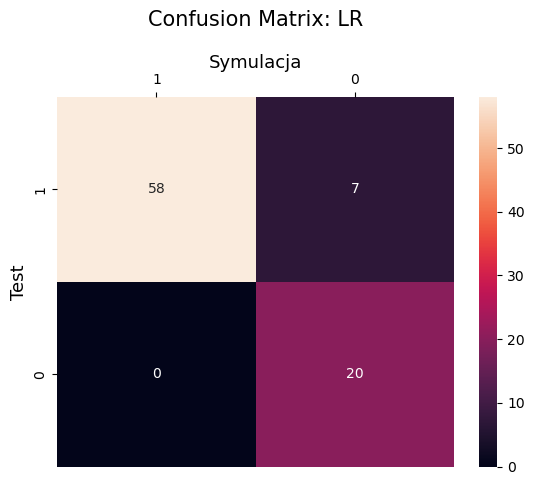

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_mix
[[55 10]
 [ 0 20]]
Classification Report for LR_mix
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        65
           1       0.67      1.00      0.80        20

    accuracy                           0.88        85
   macro avg       0.83      0.92      0.86        85
weighted avg       0.92      0.88      0.89        85



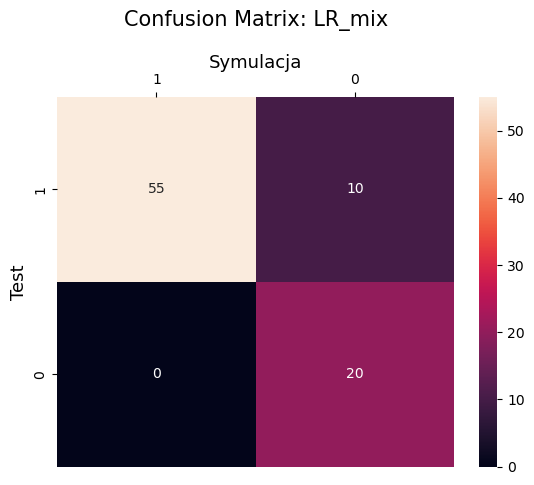

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_smote
[[59  6]
 [ 0 20]]
Classification Report for LR_smote
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        65
           1       0.77      1.00      0.87        20

    accuracy                           0.93        85
   macro avg       0.88      0.95      0.91        85
weighted avg       0.95      0.93      0.93        85



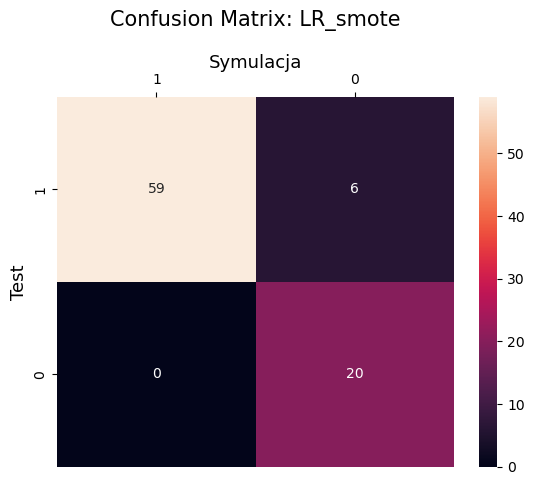

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_GAN
[[61  4]
 [ 1 19]]
Classification Report for LR_GAN
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        65
           1       0.83      0.95      0.88        20

    accuracy                           0.94        85
   macro avg       0.90      0.94      0.92        85
weighted avg       0.95      0.94      0.94        85



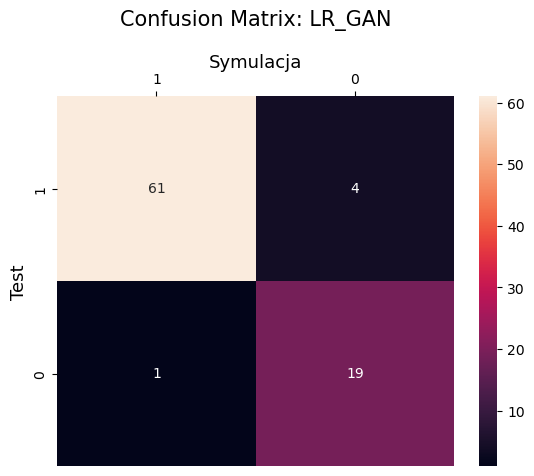

Confusion Matrix for LR_borderline
[[58  7]
 [ 0 20]]
Classification Report for LR_borderline
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        65
           1       0.74      1.00      0.85        20

    accuracy                           0.92        85
   macro avg       0.87      0.95      0.90        85
weighted avg       0.94      0.92      0.92        85



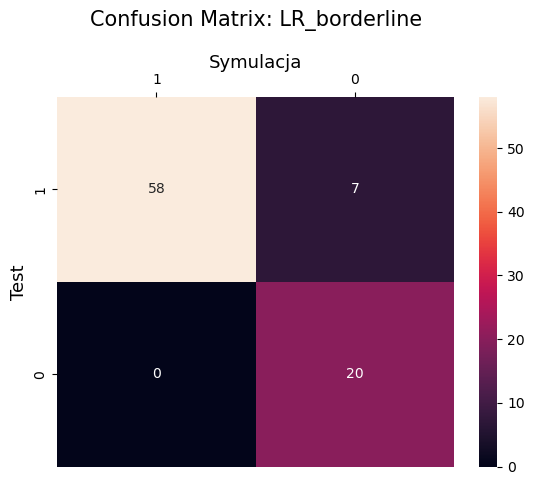

Confusion Matrix for DT
[[64  1]
 [ 1 19]]
Classification Report for DT
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        65
           1       0.95      0.95      0.95        20

    accuracy                           0.98        85
   macro avg       0.97      0.97      0.97        85
weighted avg       0.98      0.98      0.98        85



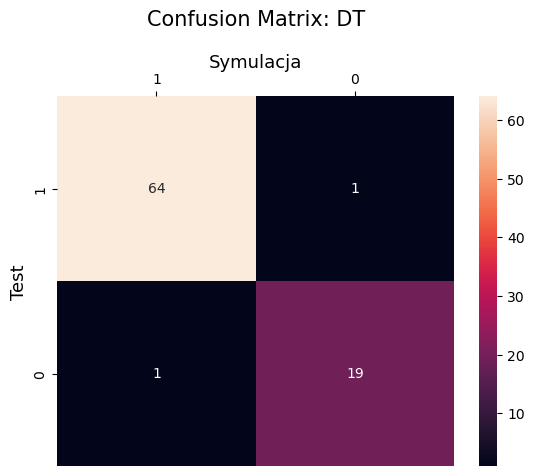

Confusion Matrix for DT_mix
[[64  1]
 [ 1 19]]
Classification Report for DT_mix
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        65
           1       0.95      0.95      0.95        20

    accuracy                           0.98        85
   macro avg       0.97      0.97      0.97        85
weighted avg       0.98      0.98      0.98        85



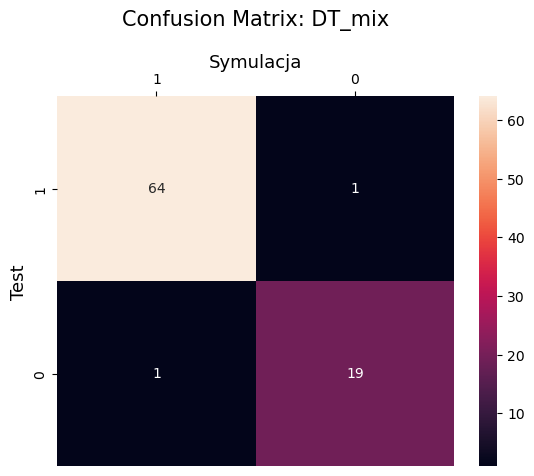

Confusion Matrix for DT_smote
[[64  1]
 [ 1 19]]
Classification Report for DT_smote
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        65
           1       0.95      0.95      0.95        20

    accuracy                           0.98        85
   macro avg       0.97      0.97      0.97        85
weighted avg       0.98      0.98      0.98        85



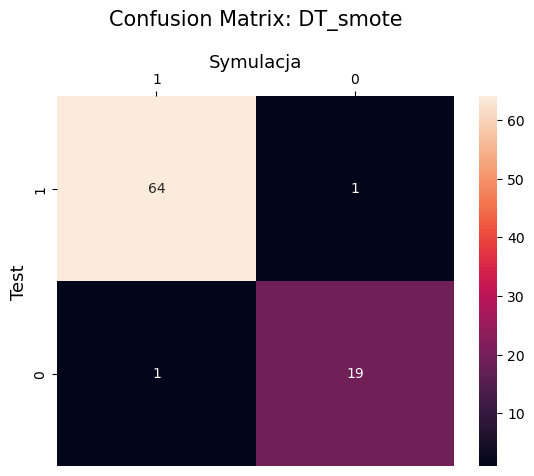

Confusion Matrix for DT_GAN
[[60  5]
 [ 1 19]]
Classification Report for DT_GAN
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        65
           1       0.79      0.95      0.86        20

    accuracy                           0.93        85
   macro avg       0.89      0.94      0.91        85
weighted avg       0.94      0.93      0.93        85



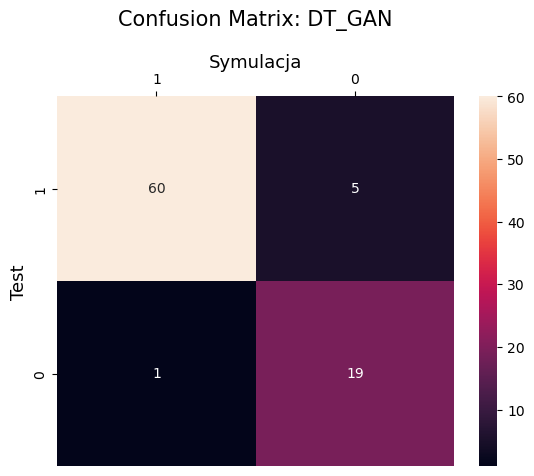

Confusion Matrix for DT_borderline
[[64  1]
 [ 1 19]]
Classification Report for DT_borderline
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        65
           1       0.95      0.95      0.95        20

    accuracy                           0.98        85
   macro avg       0.97      0.97      0.97        85
weighted avg       0.98      0.98      0.98        85



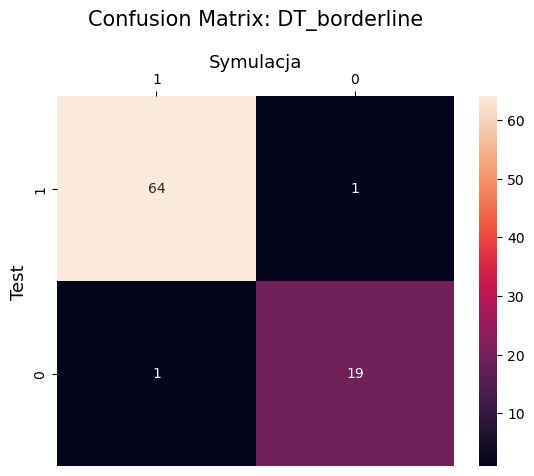

Confusion Matrix for RF
[[62  3]
 [ 0 20]]
Classification Report for RF
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.87      1.00      0.93        20

    accuracy                           0.96        85
   macro avg       0.93      0.98      0.95        85
weighted avg       0.97      0.96      0.97        85



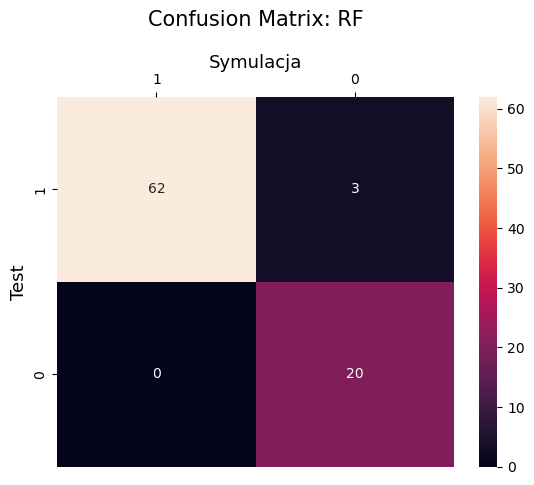

Confusion Matrix for RF_mix
[[63  2]
 [ 0 20]]
Classification Report for RF_mix
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.91      1.00      0.95        20

    accuracy                           0.98        85
   macro avg       0.95      0.98      0.97        85
weighted avg       0.98      0.98      0.98        85



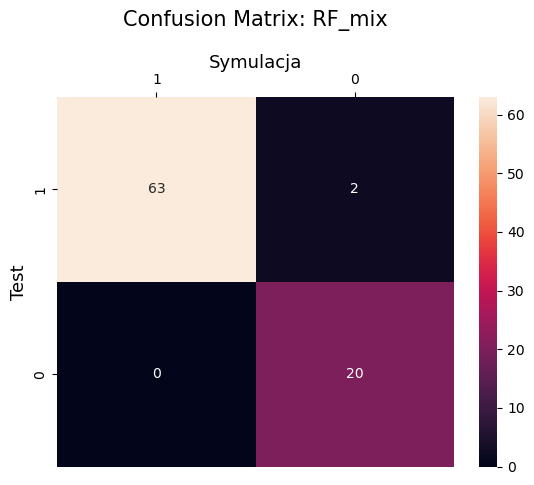

Confusion Matrix for RF_smote
[[62  3]
 [ 0 20]]
Classification Report for RF_smote
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.87      1.00      0.93        20

    accuracy                           0.96        85
   macro avg       0.93      0.98      0.95        85
weighted avg       0.97      0.96      0.97        85



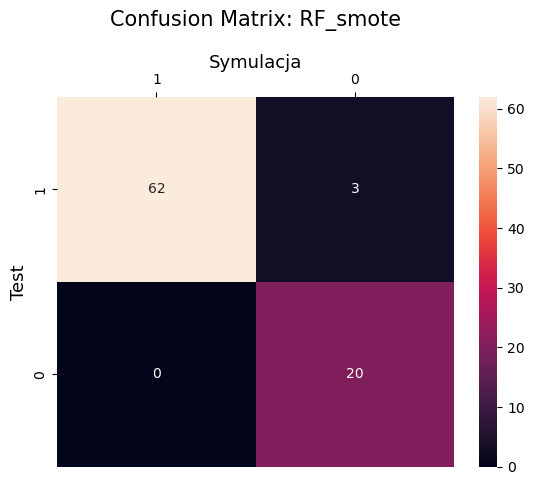

Confusion Matrix for RF_GAN
[[63  2]
 [ 0 20]]
Classification Report for RF_GAN
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.91      1.00      0.95        20

    accuracy                           0.98        85
   macro avg       0.95      0.98      0.97        85
weighted avg       0.98      0.98      0.98        85



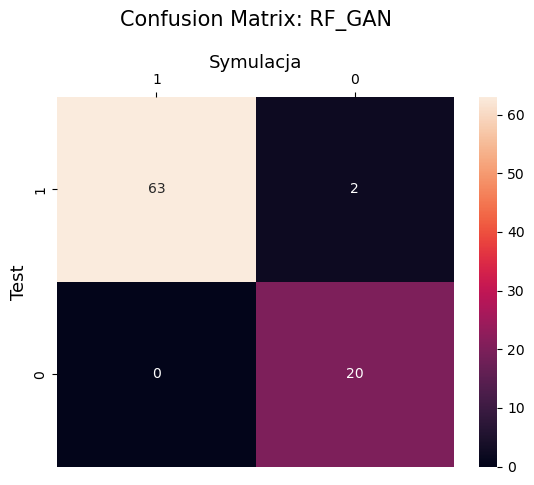

Confusion Matrix for RF_borderline
[[62  3]
 [ 0 20]]
Classification Report for RF_borderline
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.87      1.00      0.93        20

    accuracy                           0.96        85
   macro avg       0.93      0.98      0.95        85
weighted avg       0.97      0.96      0.97        85



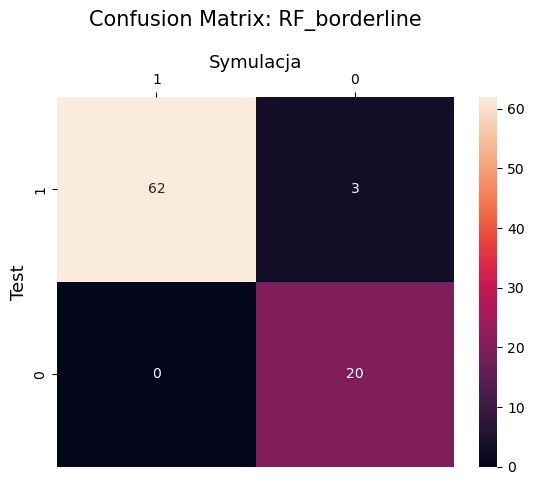

Confusion Matrix for XGB
[[63  2]
 [ 0 20]]
Classification Report for XGB
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.91      1.00      0.95        20

    accuracy                           0.98        85
   macro avg       0.95      0.98      0.97        85
weighted avg       0.98      0.98      0.98        85



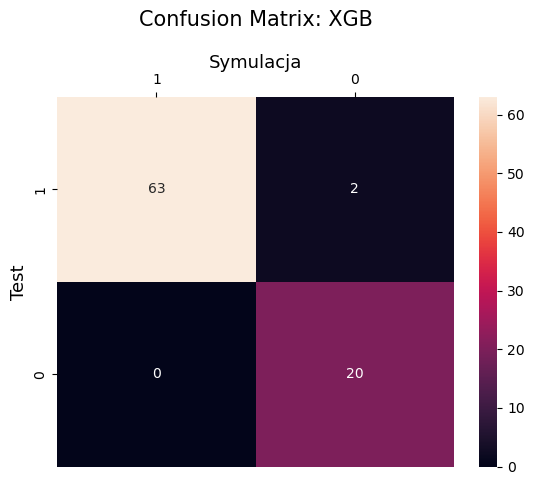

Confusion Matrix for XGB_mix
[[62  3]
 [ 0 20]]
Classification Report for XGB_mix
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.87      1.00      0.93        20

    accuracy                           0.96        85
   macro avg       0.93      0.98      0.95        85
weighted avg       0.97      0.96      0.97        85



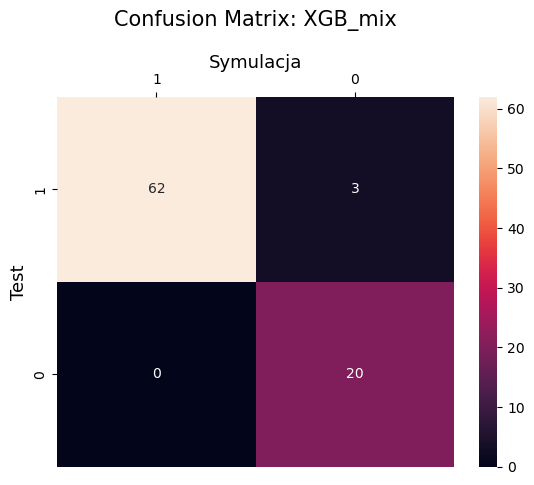

Confusion Matrix for XGB_smote
[[64  1]
 [ 0 20]]
Classification Report for XGB_smote
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       0.95      1.00      0.98        20

    accuracy                           0.99        85
   macro avg       0.98      0.99      0.98        85
weighted avg       0.99      0.99      0.99        85



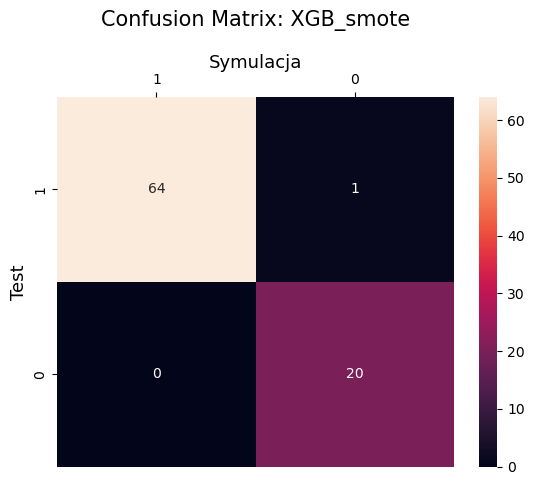

Confusion Matrix for XGB_GAN
[[63  2]
 [ 0 20]]
Classification Report for XGB_GAN
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.91      1.00      0.95        20

    accuracy                           0.98        85
   macro avg       0.95      0.98      0.97        85
weighted avg       0.98      0.98      0.98        85



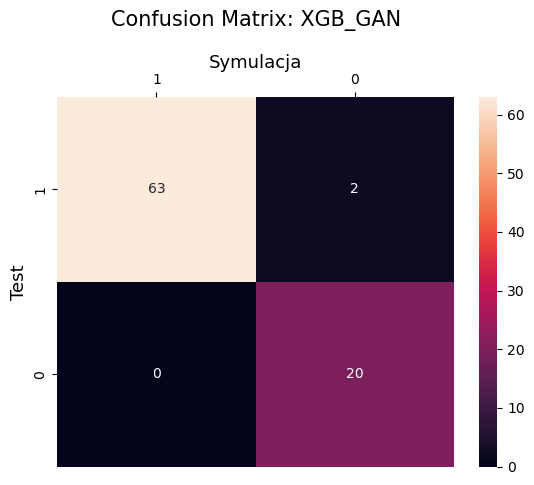

Confusion Matrix for XGB_borderline
[[63  2]
 [ 0 20]]
Classification Report for XGB_borderline
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.91      1.00      0.95        20

    accuracy                           0.98        85
   macro avg       0.95      0.98      0.97        85
weighted avg       0.98      0.98      0.98        85



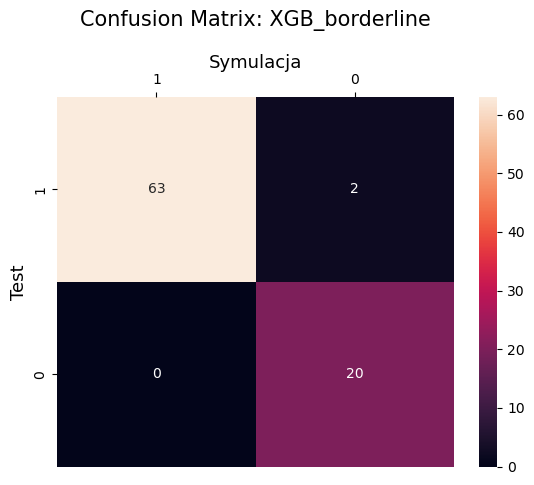

Confusion Matrix for XGBRF
[[60  5]
 [ 0 20]]
Classification Report for XGBRF
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        65
           1       0.80      1.00      0.89        20

    accuracy                           0.94        85
   macro avg       0.90      0.96      0.92        85
weighted avg       0.95      0.94      0.94        85



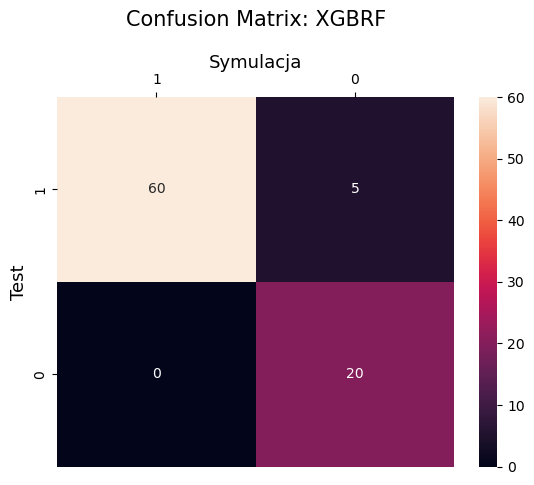

Confusion Matrix for XGBRF_mix
[[59  6]
 [ 0 20]]
Classification Report for XGBRF_mix
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        65
           1       0.77      1.00      0.87        20

    accuracy                           0.93        85
   macro avg       0.88      0.95      0.91        85
weighted avg       0.95      0.93      0.93        85



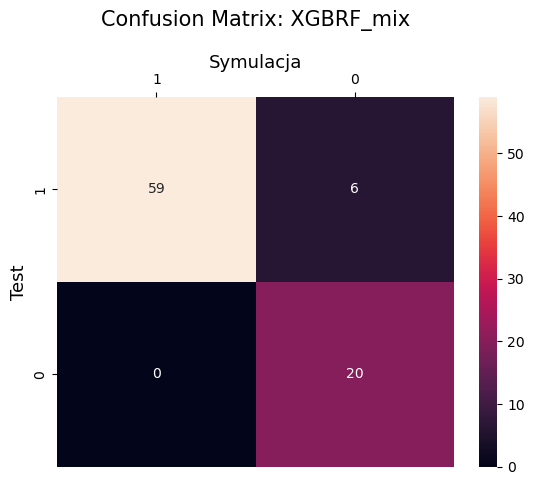

Confusion Matrix for XGBRF_smote
[[62  3]
 [ 0 20]]
Classification Report for XGBRF_smote
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.87      1.00      0.93        20

    accuracy                           0.96        85
   macro avg       0.93      0.98      0.95        85
weighted avg       0.97      0.96      0.97        85



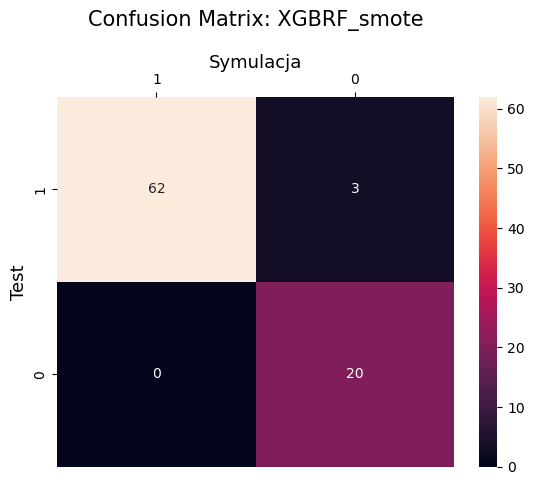

Confusion Matrix for XGBRF_GAN
[[57  8]
 [ 0 20]]
Classification Report for XGBRF_GAN
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        65
           1       0.71      1.00      0.83        20

    accuracy                           0.91        85
   macro avg       0.86      0.94      0.88        85
weighted avg       0.93      0.91      0.91        85



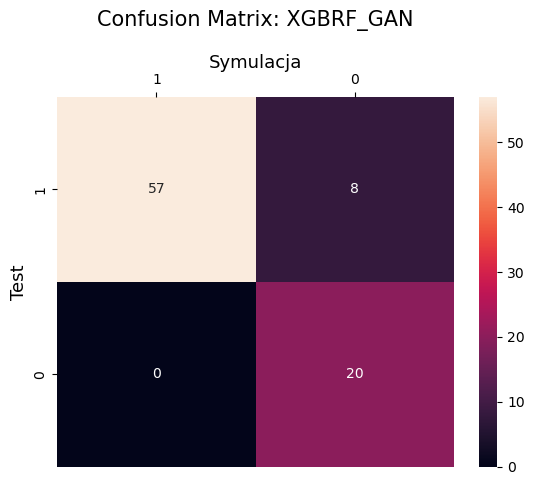

Confusion Matrix for XGBRF_borderline
[[60  5]
 [ 0 20]]
Classification Report for XGBRF_borderline
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        65
           1       0.80      1.00      0.89        20

    accuracy                           0.94        85
   macro avg       0.90      0.96      0.92        85
weighted avg       0.95      0.94      0.94        85



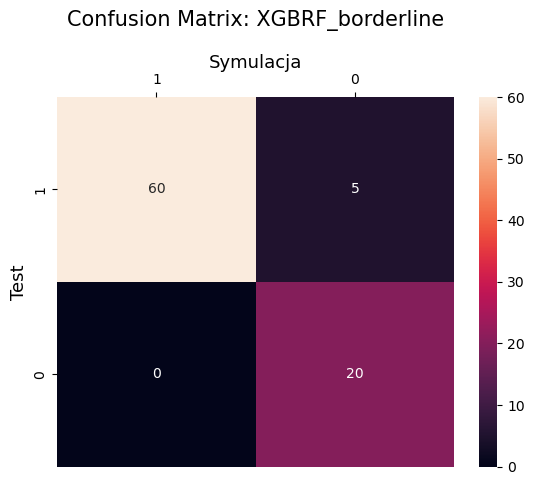

In [43]:
# generate reports + confusion matrix
for model_key, data_key in zip(models.keys(), training_data.keys()):
    X_train, y_train = training_data[data_key]
        # Load the best model using pickle
    model_filename = f"D:\\ml\\undersampling_data\\models\\ssh\\{model_key}.joblib"
    with open(model_filename, 'rb') as model_file:
        best_model = load(model_file)
        
        best_model.fit(X_train, y_train)
        # Predict using the best model
        y_pred = best_model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix for {model_key}")
        print(cm)

        cr = classification_report(y_test, y_pred)
        print(f"Classification Report for {model_key}")
        print(cr)
        
        cf = "D:\\ml\\undersampling_data\\reports\\ssh\\results\\confusion_matrix.txt"
        with open(cf, "a+") as f:
            # Zapis wyników do pliku
            print(f"Confusion Matrix for {model_key}", file=f)
            print(cm, file=f)
            print(f"Classification Report for {model_key}", file=f)
            print(cr, file=f)
        
        #make a heatmap
        sns.heatmap(cm, annot=True, xticklabels=["1", "0"], yticklabels=["1", "0"])
        plt.ylabel("Test", fontsize=13)
        plt.title(f"Confusion Matrix: {model_key}", fontsize=15, pad=20)
        plt.gca().xaxis.set_label_position("top")
        plt.xlabel("Symulacja", fontsize=13)
        plt.gca().xaxis.tick_top()
        plt.savefig(f'D:\\ml\\undersampling_data\\reports\\ssh\\results\\figures\\{model_key}.png', bbox_inches="tight", dpi=200)     
        plt.show()
        plt.close()  